# Big Data Visualization Tools

## `OnlineStats.Partition`

- Plot any-sized dataset.
- Here's a plot of 100 Million observations:

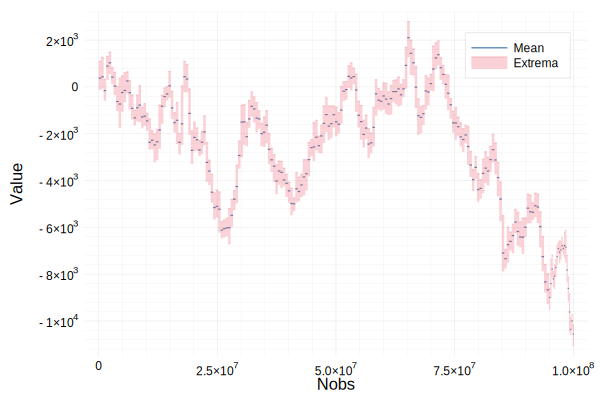

In [27]:
using OnlineStats, Plots, PlotThemes
theme(:bright)

o = Partition(Series(Mean(), Extrema()), 200)

y = randn()

for _ in 1:10^8
    fit!(o,  y += randn())
end

plot(o)

# Kaggle's [Huge Stock Market Dataset](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)

- OHLC data for each stock/ETF (each is a separate CSV) traded in the US

In [1]:
path = "/Users/joshday/datasets/price-volume-data-for-all-us-stocks-etfs/Stocks/"

# Over 7000 stocks!
readdir(path)

7195-element Array{String,1}:
 "a.us.txt"    
 "aa.us.txt"   
 "aaap.us.txt" 
 "aaba.us.txt" 
 "aac.us.txt"  
 "aal.us.txt"  
 "aamc.us.txt" 
 "aame.us.txt" 
 "aan.us.txt"  
 "aaoi.us.txt" 
 "aaon.us.txt" 
 "aap.us.txt"  
 "aapl.us.txt" 
 ⋮             
 "znh.us.txt"  
 "znwaa.us.txt"
 "zoes.us.txt" 
 "zsan.us.txt" 
 "zto.us.txt"  
 "ztr.us.txt"  
 "zts.us.txt"  
 "zumz.us.txt" 
 "zvv.us.txt"  
 "zx.us.txt"   
 "zyme.us.txt" 
 "zyne.us.txt" 

In [2]:
;head "$path/aapl.us.txt"

Date,Open,High,Low,Close,Volume,OpenInt
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0
1984-09-14,0.44052,0.45589,0.44052,0.44566,68847968,0
1984-09-17,0.45718,0.46357,0.45718,0.45718,53755262,0
1984-09-18,0.45718,0.46103,0.44052,0.44052,27136886,0
1984-09-19,0.44052,0.44566,0.43157,0.43157,29641922,0


## Statistics/Plots Directly From CSV

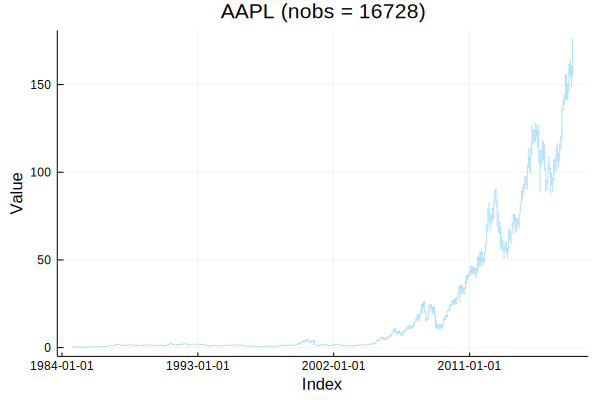

In [7]:
using Dates, CSV, Plots, OnlineStats

function plot_high_low(stock; kw...)
    o = IndexedPartition(Date, Extrema(), 500)
    for row in CSV.File("$path/$stock.us.txt") 
        fit!(o, [row.Date => row.Low, row.Date => row.High])
    end
    t = uppercase(stock) * " (nobs = $(nobs(o)))"
    plot(o; xlab="Date", title=t, legend=false, kw...)
end

plot_high_low("aapl")

## ...But this loads the entire CSV!

Even though we are creating the plots with OnlineStats, the entire file is loaded into memory.

### `CSV.Rows`

- `CSV.Rows` lets you lazily read from a CSV file
    - **Minimal memory footprint**
    - At the cost of **no type inference** (everything is treated as `String`)

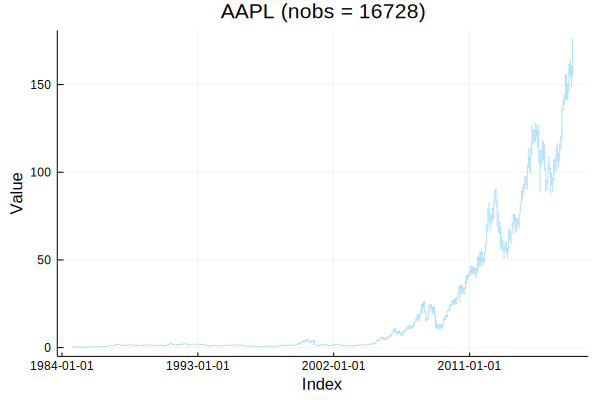

In [6]:
function plot_high_low2(stock; kw...)
    o = IndexedPartition(Date, Extrema(), 500)
    for row in CSV.Rows("$path/$stock.us.txt")
        dt = Date(row.Date, "yyyy-mm-dd")
        low = parse(Float64, row.Low)
        hi = parse(Float64, row.High)
        fit!(o, [dt => low, dt => hi])
    end
    t = uppercase(stock) * " (nobs = $(nobs(o)))"
    plot(o; xlab="Date", title=t, legend=false, kw...)
end

plot_high_low2("aapl")

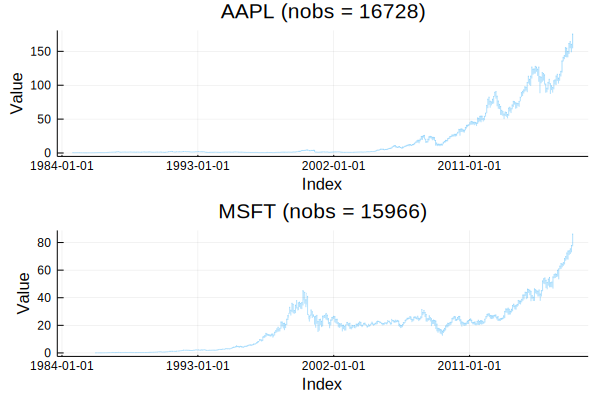

In [8]:
plot(plot_high_low2("aapl"), plot_high_low2("msft"), layout=(2,1), link=:x)

## Loading Multiple Datasets at Once

- Working with only one CSV at a time limits what kinds of analyses we can do.

In [29]:
using JuliaDB

┌ Info: Precompiling JuliaDB [a93385a2-3734-596a-9a66-3cfbb77141e6]
└ @ Base loading.jl:1273


In [ ]:
t = loadtable(path, filenamecol="stock")

# TrueFX API

In [ ]:
using Dates, CSV

function get_data(q = "")
    endpoint = "https://webrates.truefx.com/rates/connect.html?f=csv&$q"
    hdr = [:pair, :utc, :big_bid_figure, :bid_points, :offer_bid_figure,
           :offer_points, :high, :low, :open]
    CSV.read(download(endpoint); header=hdr, footerskip=1)
end

In [ ]:
get_data()

In [ ]:
get_data("c=EUR/USD")

In [ ]:
using OnlineStats, Plots
theme(:juno)
gr()

o = IndexedPartition(Int, Extrema(), 10)

while true
    IJulia.clear_output(true)
    df = get_data("c=USD/JPY")
    fit!(o, (df[1, :utc], df[1, :bid_points]))
    display(plot(o, xlab="UTC Time", ylab="Bid Points", title="nobs = $(nobs(o))"))
end